The rasters we would like to use for training are of differing extents. This notebook outlines a workflow to crop them to be of consistent extents

In [1]:
# GIS imports
import rasterio
from shapely.geometry import box
import geopandas as gpd

# Numpy imports
import numpy as np

# plotting imports
import matplotlib.pyplot as plt

# misc imports
import pathlib
from pathlib import Path
from functools import partial

In [2]:
input_data_path = Path('../data/baker_csm_stack/original_rasters/')
output_data_path = Path('../data/baker_csm_stack/cropped_rasters/')

In [3]:
# files of interest
left_ortho_image = input_data_path  / 'final_ortho_left_1.0m_holes_filled.tif'
right_ortho_image = input_data_path  / 'final_ortho_right_1.0m_holes_filled.tif'
stereo_dem_image = input_data_path / 'try_pc_align_to_lidar_15m_maxdisp_rotationallowed-1.0m-DEM.tif'
intersection_error_image = input_data_path / 'try_pc_align_to_lidar_15m_maxdisp_rotationallowed-1.0m-IntersectionErr_holes_filled.tif'
lidar_dem_image = input_data_path / 'mosaic_full128_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif'

In [4]:
# Open files, create shapely polygons from bounds, intersect them and find common overlap
# Then perform a windowed read of the files, and write out the cropped rasters
with rasterio.open(left_ortho_image) as ds:
    left_ortho_shape = box(*ds.bounds)
    left_ortho_crs = ds.crs

with rasterio.open(right_ortho_image) as ds:
    right_ortho_shape = box(*ds.bounds)

with rasterio.open(stereo_dem_image) as ds:
    stereo_dem_shape = box(*ds.bounds)

with rasterio.open(intersection_error_image) as ds:
    triangulation_error_shape = box(*ds.bounds)

with rasterio.open(lidar_dem_image) as ds:
    lidar_dem_shape = box(*ds.bounds)
    lidar_crs = ds.crs

In [5]:
raster_shape_list = [left_ortho_shape, right_ortho_shape, stereo_dem_shape, triangulation_error_shape, lidar_dem_shape]
intersection_shape =  left_ortho_shape
for s in raster_shape_list:
    intersection_shape = intersection_shape.intersection(s)

print("final bounds: ", intersection_shape.bounds)

final bounds:  (583047.5, 5395041.5, 590976.5, 5410936.5)


In [6]:
geometry_dict = {'geometry':[lidar_dem_shape, left_ortho_shape, intersection_shape]}
df = gpd.GeoDataFrame(geometry_dict, crs=lidar_crs)

<Axes: >

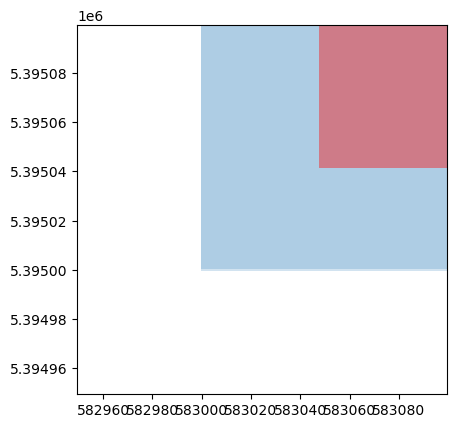

In [7]:
ax = df.iloc[:2].geometry.plot(alpha=0.2)
ax.set_ylim(5394999.5-50, 5394999.5+100)
ax.set_xlim(582999.5-50, 582999.5+100)
gpd.GeoSeries(df.iloc[2]).plot(ax=ax, color='red', alpha=0.4)

The difference between the first two geometries is tiny (present only in the y-direction), whereas the final intersection geometry is significantly inset

In [8]:
type(intersection_shape)

shapely.geometry.polygon.Polygon

In [9]:
def write_cropped_images(input_img_file:pathlib.Path, output_path:pathlib.Path, reference_shape:box):
    """Perform windowed read of an input image and write out the resulting raster

    Args:
        input_img_file (pathlib.Path): Location of input image
        output_path (pathlib.Path): Path to which output raster will be written
        reference_shape (shapely.geometry.polygon.Polygon): Shapely polygon whose bounds describe the window to read
    """
    with rasterio.open(input_img_file) as ds:
        img = ds.read(1, window=rasterio.windows.from_bounds(*reference_shape.bounds, ds.transform))
        profile = ds.profile

    output_transform = rasterio.windows.transform(rasterio.windows.from_bounds(*intersection_shape.bounds, ds.transform), profile['transform'])

    profile.update({
        'width':img.shape[-1],
        'height':img.shape[-2],
        'transform':output_transform
        })
    
    with rasterio.open(output_path / input_img_file.name, 'w', **profile) as ds:
        ds.write(img.reshape(1, *img.shape))


In [10]:
filenames = [left_ortho_image, right_ortho_image, stereo_dem_image, intersection_error_image, lidar_dem_image]
partial_func = partial(write_cropped_images, output_path=output_data_path, reference_shape=intersection_shape)

_ = list(map(partial_func, filenames))

In [11]:
# sanity check to ensure the output rasters have the same bounds as the window
for f in filenames:
    with rasterio.open(output_data_path/f.name) as ds:
        assert ds.bounds == intersection_shape.bounds, "Bounds mismatch!"

In [12]:
# Let's also generate a 'nodata' mask that can be used during our deep learning step
nodata_mask = None

for f in list(output_data_path.glob('*.tif')):
    with rasterio.open(f) as ds:
        if ds.profile['nodata'] is not None:
            img = ds.read()
            nodata_val = ds.profile['nodata']
        else:
            continue
    
    if nodata_mask is None:
        nodata_mask = np.where(img==nodata_val, True, False)
    else:
        nodata_mask = nodata_mask | np.where(img==nodata_val, True, False)

nodata_mask = nodata_mask.astype(int)

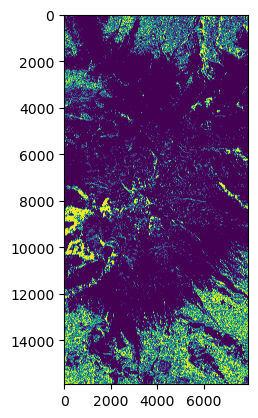

In [13]:
plt.imshow(nodata_mask[0], interpolation=None)

We visualize the datasets further in the next notebook. For now, let's write out our `nodata` mask

In [14]:
# re-open the last file read to get a template profile
with rasterio.open(f) as ds:
    profile = ds.profile

# update relevant fields
profile.update({
    'dtype':np.uint8,
    'nodata':None
})
with rasterio.open(output_data_path/'nodata_mask.tif', 'w', **profile) as ds:
    ds.write(nodata_mask)